In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show(img, title=None):
    npimg = img.numpy()
    plt.figure()
    if title is not None:
        plt.title(title)
    npimg = np.transpose(npimg, (1,2,0))
    cmap = None
    if npimg.shape[-1] not in [3,4]:
        npimg = npimg[:,:,0]
        cmap = 'gray'
    plt.imshow(npimg, interpolation='nearest', cmap=cmap)

In [3]:
epochs = 10

# CelebA Data

In [4]:
batch_size = 128

In [5]:
from data import CelebA
dataset = CelebA(transform=transforms.Compose([
                    transforms.Grayscale(),
                    transforms.Resize((256, 256)), 
                    transforms.ToTensor()]),
                  label='male'
                 )

In [6]:
data_loader = torch.utils.data.DataLoader(dataset, num_workers=4, batch_size=128)

In [7]:
idcs = np.arange(len(dataset))
np.random.seed(0) # This is important to split the same way every single time
np.random.shuffle(idcs)
split_idx = int(0.9 * len(dataset))
train_idcs = idcs[:split_idx]
test_idcs = idcs[split_idx:]

In [8]:
train_dataset = torch.utils.data.Subset(dataset, train_idcs)
test_dataset = torch.utils.data.Subset(dataset, test_idcs)

### Toggle cell below for sample debugging

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)
    
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)

# Classifier Model

In [10]:
from models import Classifier

In [11]:
device = torch.device("cuda")

In [12]:
model = Classifier(2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [13]:
import torch.nn.functional as F

def train(epoch):
    model.train()
    train_loss = 0
    total_corr = 0
    for data, genders in tqdm(train_loader):
        genders = genders.to(device)
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data)
                
        num_corr = torch.eq(genders, torch.argmax(pred, dim=1)).sum()
        total_corr += num_corr
        
        gender_one_hot_encoding = torch.zeros(pred.shape)
        for row_idx in range(gender_one_hot_encoding.shape[0]):
            gender_one_hot_encoding[row_idx, genders[row_idx]] = 1.0
        gender_one_hot_encoding = gender_one_hot_encoding.to(device)
                
        loss = F.binary_cross_entropy(pred.float(), gender_one_hot_encoding.float())
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    acc = total_corr.float() / len(train_loader.dataset)
    print('====> Epoch: {} acc: {:.4f} avg loss: {:.4f}'.format(
          epoch, acc, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    total_corr = 0
    with torch.no_grad():
        for data, genders in tqdm(test_loader):  
            genders = genders.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            pred = model(data)

            num_corr = torch.eq(genders, torch.argmax(pred, dim=1)).sum()
            total_corr += num_corr

            gender_one_hot_encoding = torch.zeros(pred.shape)
            for row_idx in range(gender_one_hot_encoding.shape[0]):
                gender_one_hot_encoding[row_idx, genders[row_idx]] = 1.0
            gender_one_hot_encoding = gender_one_hot_encoding.to(device)

            test_loss += F.binary_cross_entropy(pred.float(), gender_one_hot_encoding.float()).item()

    test_loss /= len(test_loader.dataset)
    acc = total_corr.float() / len(test_loader.dataset)
    print('====> Test acc: {:.4f}, loss: {:.4f}'.format(acc, test_loss))

# Load

In [14]:
weight_path = 'weights/{}_{}.pt'.format(model.__class__.__name__, dataset.__class__.__name__)
weight_path

'weights/Classifier_CelebA.pt'

In [15]:
import os
if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path))    

# Train

In [16]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

  0%|          | 0/159 [00:00<?, ?it/s]

====> Epoch: 1 acc: 0.8597 avg loss: 0.0030


  0%|          | 0/1425 [00:00<?, ?it/s]

====> Test acc: 0.8911, loss: 0.0025


  0%|          | 0/159 [00:00<?, ?it/s]

====> Epoch: 2 acc: 0.9033 avg loss: 0.0022


  0%|          | 0/1425 [00:00<?, ?it/s]

====> Test acc: 0.9168, loss: 0.0019


  0%|          | 0/159 [00:00<?, ?it/s]

====> Epoch: 3 acc: 0.9207 avg loss: 0.0017


  0%|          | 0/1425 [00:00<?, ?it/s]

====> Test acc: 0.9290, loss: 0.0016


  0%|          | 0/159 [00:00<?, ?it/s]

====> Epoch: 4 acc: 0.9301 avg loss: 0.0015


  0%|          | 0/1425 [00:00<?, ?it/s]

====> Test acc: 0.9362, loss: 0.0014


  0%|          | 0/159 [00:00<?, ?it/s]

====> Epoch: 5 acc: 0.9358 avg loss: 0.0014


  0%|          | 0/1425 [00:00<?, ?it/s]

====> Test acc: 0.9409, loss: 0.0013


  0%|          | 0/159 [00:00<?, ?it/s]

====> Epoch: 6 acc: 0.9395 avg loss: 0.0013


  0%|          | 0/1425 [00:00<?, ?it/s]

====> Test acc: 0.9442, loss: 0.0012


  0%|          | 0/159 [00:00<?, ?it/s]

====> Epoch: 7 acc: 0.9430 avg loss: 0.0012


  0%|          | 0/1425 [00:00<?, ?it/s]

====> Test acc: 0.9472, loss: 0.0011


  0%|          | 0/159 [00:00<?, ?it/s]

====> Epoch: 8 acc: 0.9455 avg loss: 0.0011


  0%|          | 0/1425 [00:00<?, ?it/s]

====> Test acc: 0.9499, loss: 0.0011


  0%|          | 0/159 [00:00<?, ?it/s]

====> Epoch: 9 acc: 0.9480 avg loss: 0.0011


  0%|          | 0/1425 [00:00<?, ?it/s]

====> Test acc: 0.9512, loss: 0.0011


  0%|          | 0/159 [00:00<?, ?it/s]

====> Epoch: 10 acc: 0.9499 avg loss: 0.0010


100%|██████████| 159/159 [00:20<00:00,  7.76it/s]

====> Test acc: 0.9524, loss: 0.0010


# Save

In [17]:
torch.save(model.state_dict(), weight_path)

# Try it

In [18]:
import os
if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path))    

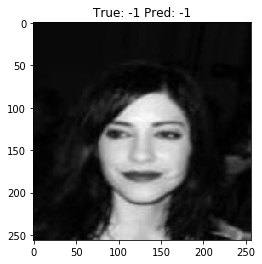

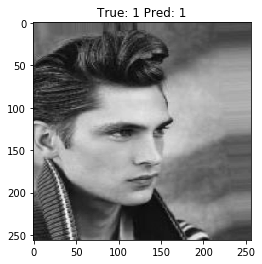

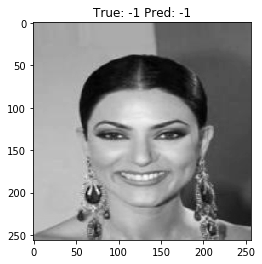

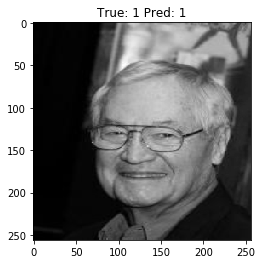

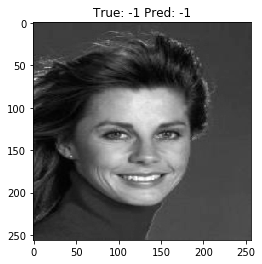

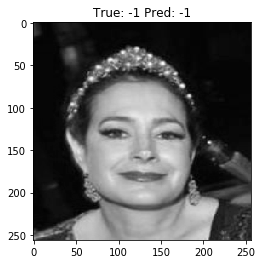

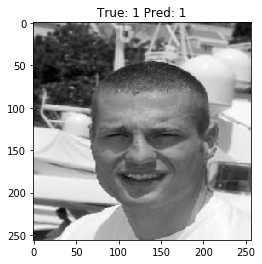

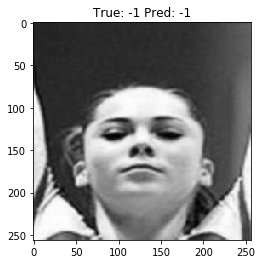

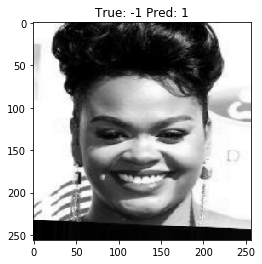

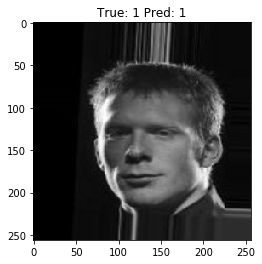

In [19]:
model.eval()

for idx in torch.utils.data.RandomSampler(test_dataset, num_samples=10, replacement=True):
    a_face, gender = test_dataset[idx]
    
    a_face = a_face.to(device)
    a_face = a_face.unsqueeze(0)
    
    pred = model(a_face)
    
    pred_idx = torch.argmax(pred, dim=1)
    gender_idx = gender
    
    pred_class = dataset.classes[pred_idx]
    gender_class = dataset.classes[gender_idx]
    
    
    show(a_face.cpu().view(1,256,256), 'True: {} Pred: {}'.format(gender_class, pred_class))